In [2]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid",context='talk', font_scale=1.1)
%matplotlib inline

import scipy as scp
import pandas as pd
import copy as cp
from tqdm import tqdm 
from itertools import cycle

import pymc as pm
import arviz as az
import numpy as np

RANDOM_SEED = 8927

In [5]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Tue Jan 16 2024

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

scipy     : 1.11.3
seaborn   : 0.13.0
matplotlib: 3.8.1
pymc      : 5.9.1
arviz     : 0.16.1
numpy     : 1.25.2
pandas    : 2.1.2

Watermark: 2.4.3



# Figure 1C

The Bayesian analyses of the mouth-form polyphenism 

In [2]:
MF_ratio = pd.read_csv('./MF_ratios.csv', sep=',', index_col=0)

In [3]:
def calculate_stat(diet, strain, dataset):
    G_samples = list(dataset[(dataset['Culture']==diet) & (dataset['Strain']==strain)]['Eu'])
    N_samples = list(dataset[(dataset['Culture']==diet) & (dataset['Strain']==strain)]['Total'])
    group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
    data = []
    for i in range(0, len(N_samples)):
        data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    with pm.Model() as model:
        μ = pm.Beta('μ', 1., 1.)
        κ = pm.HalfNormal('κ', 10)
        θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
        y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
        trace = pm.sample(tune=5000, draws=10000, target_accept=0.95, random_seed=RANDOM_SEED)
    return trace

In [4]:
data = {}
for i in ['OP50', 'Novo']:
    for j in ['RSC017']:
        data[i + '_' + j] = calculate_stat(i, j, MF_ratio)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, κ, θ]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, κ, θ]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 8 seconds.


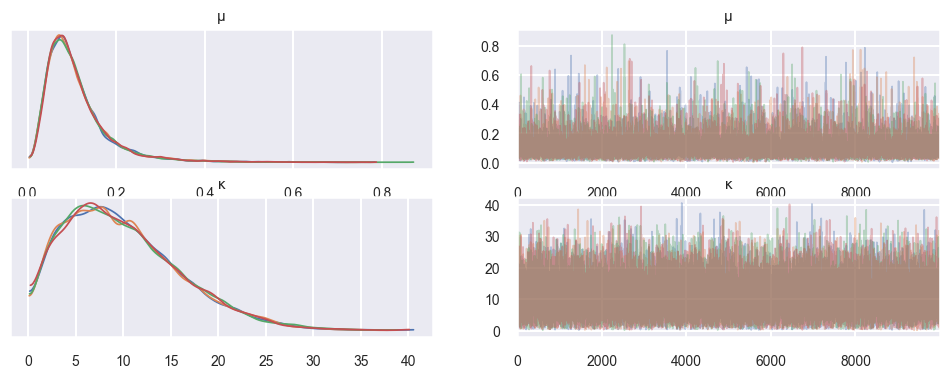

In [5]:
az.plot_trace(data['OP50_RSC017'], var_names=['μ', 'κ'], compact=False);

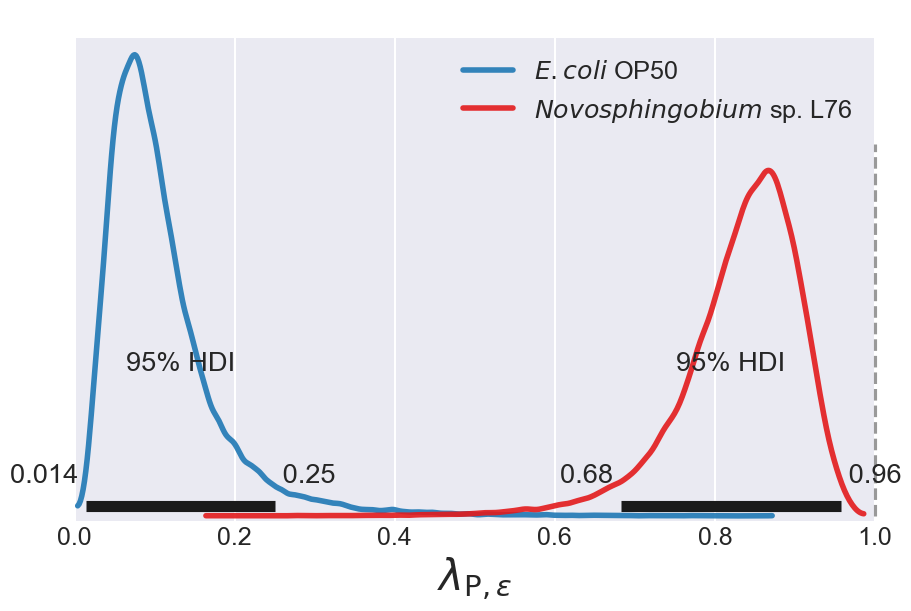

In [6]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(9, 6),
    constrained_layout=True)

az.plot_posterior(data['OP50_RSC017'], var_names=['μ'], hdi_prob=0.95, ax=ax, point_estimate=None, round_to=2, alpha=0.9, color=sns.color_palette('Paired')[1], textsize=18, lw=4, label=r'$\it{E. coli}$ OP50')

az.plot_posterior(data['Novo_RSC017'], var_names=['μ'], hdi_prob=0.95, ax=ax, point_estimate=None, round_to=2, alpha=0.9, color=sns.color_palette('Paired')[5], lw=4, textsize=18, label=r'$\it{Novosphingobium}$ sp. L76')

ax.vlines(1, 0., 7., linestyles='dashed', color='gray', clip_on=False, alpha=0.8)

#ax.text(0.03, 0.5, r'$\it{E. coli}$', fontsize='x-small')
ax.set(title=r' ', ylim=(-0.1,9), xlim=(0,1))

ax.set_xlabel(r'$\lambda_{\mathrm{P},\epsilon}$', fontsize=30)

ax.legend(frameon=False)

ax.spines['bottom'].set_visible(False)

plt.tick_params(axis='x', which='both', size=0)

# Figure 1D

In [7]:
fec_data = pd.read_csv('./fec_data.csv', sep=',', index_col=0)

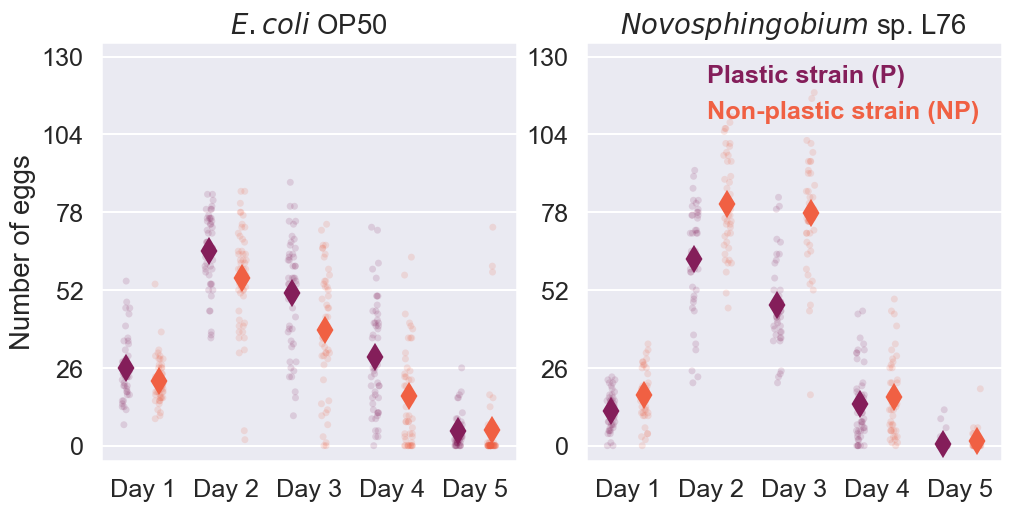

In [9]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    constrained_layout=True)

axes = axes.flatten()

pal = 'rocket'
sns.stripplot(data=fec_data[fec_data['Diet']=='OP50'], x='Day', y='Progeny Count', hue='Strain', hue_order=['RSC017', 'RS5405'], dodge=True, ax=axes[0], palette=pal, alpha=0.15, zorder=1)

sns.stripplot(data=fec_data[fec_data['Diet']=='Novo'], x='Day', y='Progeny Count', hue='Strain', hue_order=['RSC017', 'RS5405'], dodge=True, ax=axes[1], palette=pal, alpha=0.15, zorder=1)

sns.pointplot(
    data=fec_data[fec_data['Diet']=='OP50'], x='Day', y='Progeny Count', hue='Strain', hue_order=['RSC017', 'RS5405'],
    linestyle='none', dodge=.6 - .6 / 3., palette=pal,
    markers="d", errorbar=None, ax=axes[0])

sns.pointplot(
    data=fec_data[fec_data['Diet']=='Novo'], x='Day', y='Progeny Count', hue='Strain', hue_order=['RSC017', 'RS5405'],
    linestyle='none', dodge=.6 - .6 / 3., palette=pal,
    markers="d", errorbar=None, ax=axes[1])

axes[0].set(xlabel='', ylim=(-5, 135), title=r'$\it{E. coli}$ OP50', yticks=np.linspace(0, 130, 6), ylabel='Number of eggs');
axes[1].set(xlabel='', ylabel='', ylim=(-5, 135), title=r'$\it{Novosphingobium}$ sp. L76', yticks=np.linspace(0, 130, 6));

axes[0].legend([], frameon=False)

handles, labels = axes[1].get_legend_handles_labels()

axes[1].legend(handles=[handles[2], handles[3]], labels=['Plastic strain (P)', 'Non-plastic strain (NP)'], frameon=False, markerscale=0, handlelength=0, handleheight=0.1, labelcolor='linecolor', prop={'weight':'bold'});

# Figure 1F

In [4]:
%run metapop_alt.py

<Figure size 640x480 with 0 Axes>

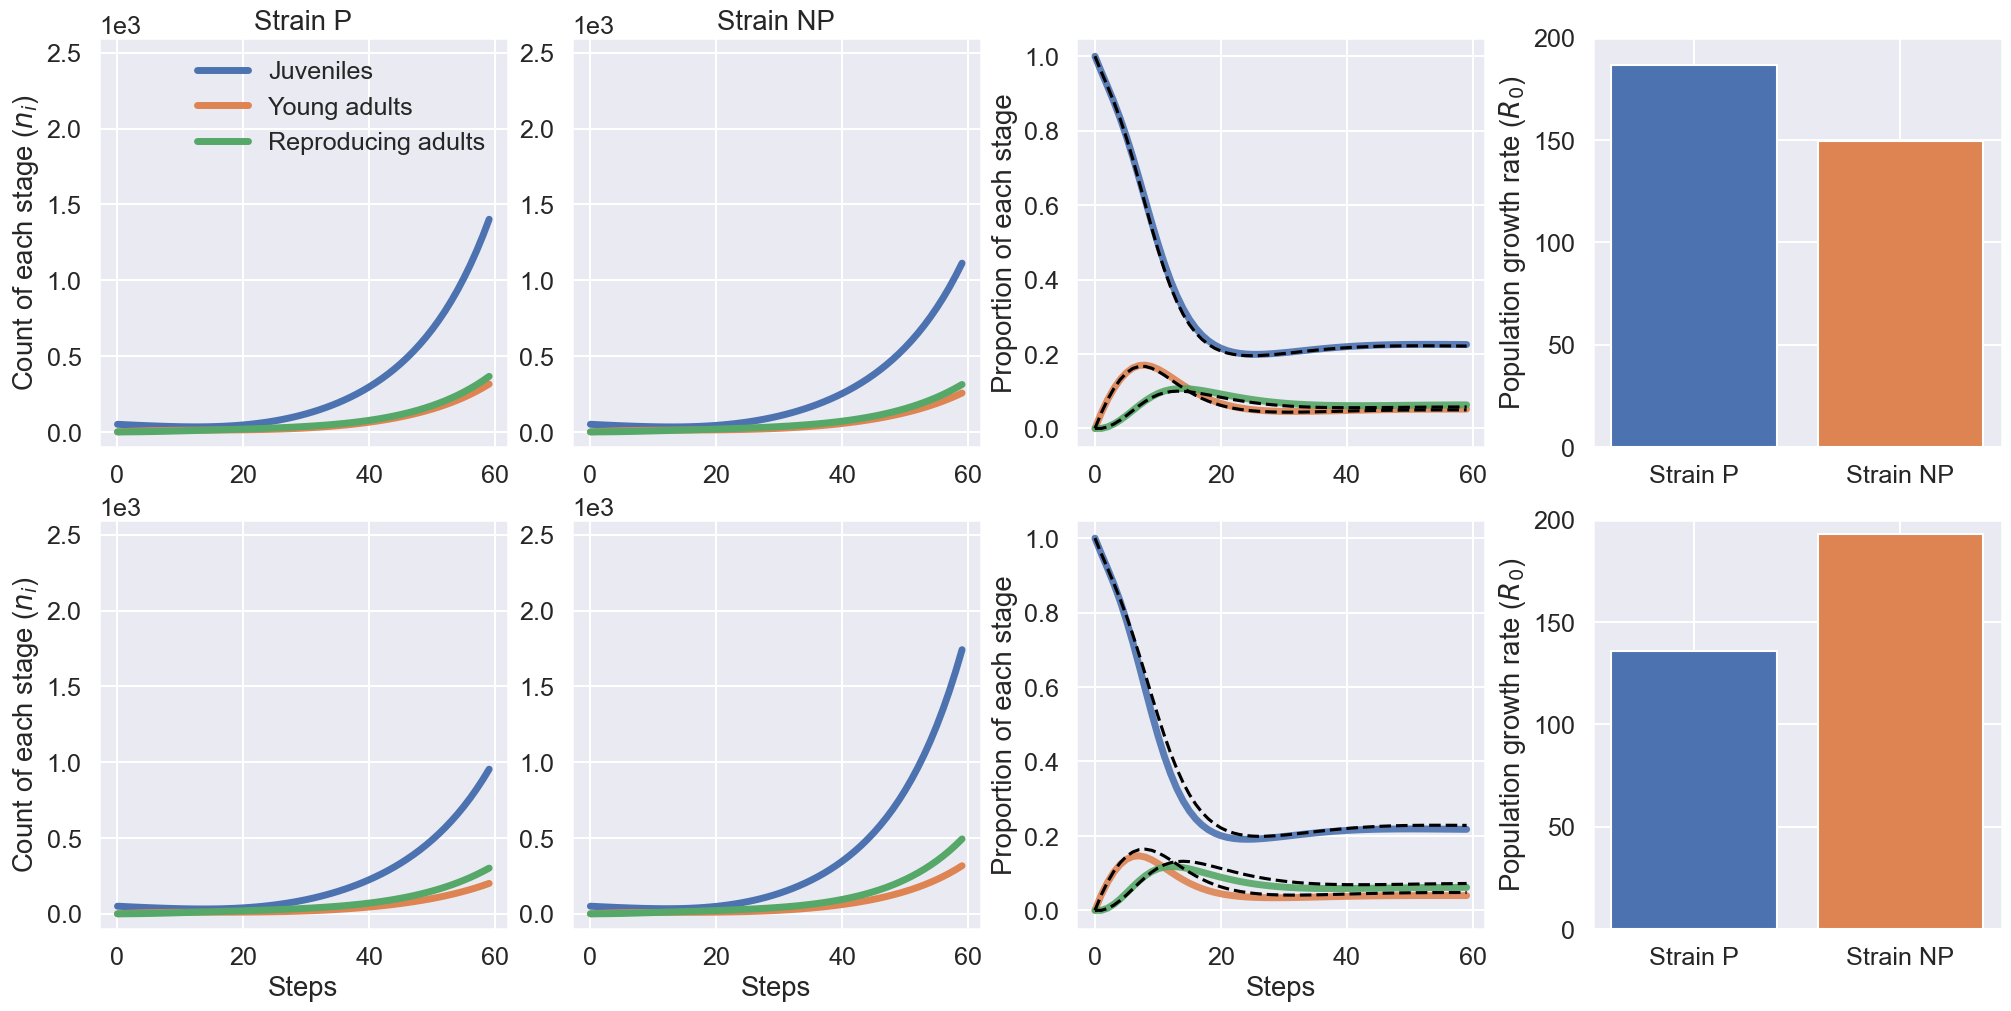

In [5]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(20, 10),
    constrained_layout=True)

axes = axes.flatten()

n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, α=0.0)
pop.diet = 'OP50'
n_list = []
for i in range(60):
    n_list.append(pop.pop)
    pop.take_a_step()
    
axes[0].plot([m[1][0] for m in n_list], lw=5, label='Juveniles')
axes[0].plot([m[3][0] for m in n_list], lw=5, label='Young adults')
axes[0].plot([np.sum(m[4:9]) for m in n_list], lw=5, label='Reproducing adults')
axes[0].legend(frameon=False)

axes[1].plot([m[11][0] for m in n_list], lw=5, label='Juveniles')
axes[1].plot([m[13][0] for m in n_list], lw=5, label='Young adults')
axes[1].plot([np.sum(m[14:19]) for m in n_list], lw=5, label='Reproducing adults')

axes[2].plot([m[11][0]/np.sum(m[10:]) for m in n_list], color=sns.color_palette()[0], alpha=0.9, lw=5, label='Juveniles')
axes[2].plot([m[13][0]/np.sum(m[10:]) for m in n_list], color=sns.color_palette()[1], alpha=0.9, lw=5, label='Young adults')
axes[2].plot([np.sum(m[14:19])/np.sum(m[10:]) for m in n_list], color=sns.color_palette()[2], alpha=0.9, lw=5, label='Reproducing adults')


axes[2].plot([m[1][0]/np.sum(m[:10]) for m in n_list], color='black', ls='--')
axes[2].plot([m[3][0]/np.sum(m[:10]) for m in n_list], color='black', ls='--')
axes[2].plot([np.sum(m[4:9])/np.sum(m[:10]) for m in n_list], color='black', ls='--')



axes[2].legend([],[],frameon=False)

axes[0].set(ylabel=r'Count of each stage ($n_i$)', title='Strain P')

axes[1].set(title='Strain NP')

axes[2].set(ylabel='Proportion of each stage')

axes[3].bar([1, 2], [pop.growth_rate[0], pop.growth_rate[1]], color=[sns.color_palette()[0] , sns.color_palette()[1]])

axes[3].set(xticks=[1,2], xticklabels=['Strain P', 'Strain NP'])

for i in axes[:2]:
    # i.set_xlabel('Steps')
    i.set_ylim(-100, 2600)
    i.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
axes[3].set(ylabel=r'Population growth rate ($R_0$)', ylim=(0,200), yticks=np.linspace(0, 200, 5))


n0 = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, consumption=0.01, α=0.0)
pop.diet = 'Novo'
n_list = []
for i in range(60):
    n_list.append(pop.pop)
    pop.take_a_step()

    
axes[4].plot([m[1][0] for m in n_list], lw=5, label='Juveniles')
axes[4].plot([m[3][0] for m in n_list], lw=5, label='Young adults')
axes[4].plot([np.sum(m[4:9]) for m in n_list], lw=5, label='Reproducing adults')
#axes[4].legend(frameon=False)

axes[5].plot([m[11][0] for m in n_list], lw=5, label='Juveniles')
axes[5].plot([m[13][0] for m in n_list], lw=5, label='Young adults')
axes[5].plot([np.sum(m[14:19]) for m in n_list], lw=5, label='Reproducing adults')    

axes[6].plot([m[11][0]/np.sum(m[10:]) for m in n_list], color=sns.color_palette()[0], alpha=0.9, lw=5, label='Juveniles')
axes[6].plot([m[13][0]/np.sum(m[10:]) for m in n_list], color=sns.color_palette()[1], alpha=0.9, lw=5, label='Young adults')
axes[6].plot([np.sum(m[14:19])/np.sum(m[10:]) for m in n_list], color=sns.color_palette()[2], alpha=0.9, lw=5, label='Reproducing adults')


axes[6].plot([m[1][0]/np.sum(m[:10]) for m in n_list], color='black', ls='--')
axes[6].plot([m[3][0]/np.sum(m[:10]) for m in n_list], color='black', ls='--')
axes[6].plot([np.sum(m[4:9])/np.sum(m[:10]) for m in n_list], color='black', ls='--')

axes[6].legend([],[],frameon=False)

axes[4].set(ylabel=r'Count of each stage ($n_i$)')


axes[6].set(ylabel='Proportion of each stage')

axes[7].bar([1, 2], [pop.growth_rate[0], pop.growth_rate[1]], color=[sns.color_palette()[0] , sns.color_palette()[1]])

axes[7].set(xticks=[1,2], xticklabels=['Strain P', 'Strain NP'])

for i in axes[4:6]:
    i.set_xlabel('Steps')
    i.set_ylim(-100, 2600)
    i.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
axes[7].set(ylabel=r'Population growth rate ($R_0$)', ylim=(0,200), yticks=np.linspace(0, 200, 5))
axes[6].set_xlabel('Steps');

In [2]:
%run metapop.py

# Figure 2A

[Text(0.5, 1.0, 'With predation')]

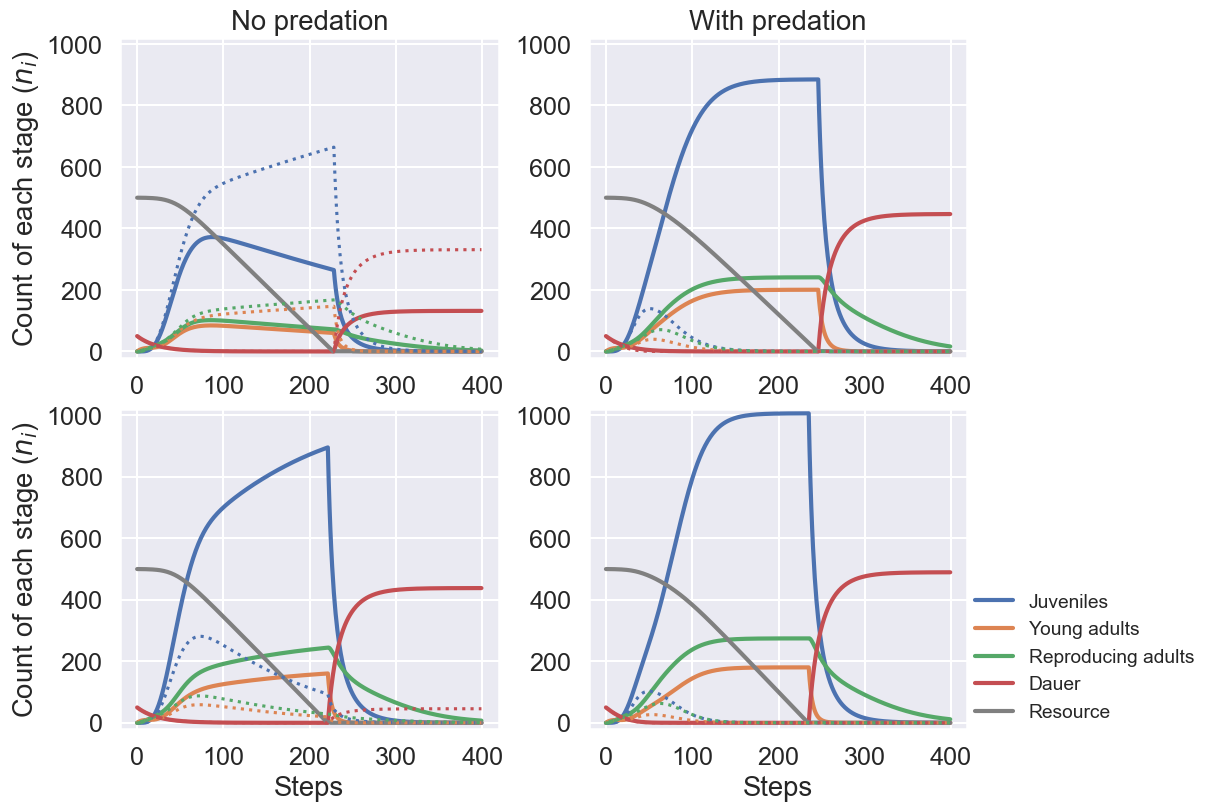

In [15]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 8),
    constrained_layout=True)

axes = axes.flatten()

for i in axes:
    i.set_ylim(-20, 1020)

r_init = 500
ρ = 0.002
time = 400
fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}

n0 = np.array([[0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, fec_pars, mf_prob, consumption=ρ,  r0=r_init, α=0.0)
pop.diet = 'OP50'
n_list = []
r_list = []
for i in range(time):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[0].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[0].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[0].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[0].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[0].plot(r_list, lw=3, color='gray', label='Resource')


axes[0].plot([m[1][0] for m in n_list], color=sns.color_palette()[0], ls='dotted')
axes[0].plot([m[3][0] for m in n_list], color=sns.color_palette()[1], ls='dotted')
axes[0].plot([np.sum(m[4:9]) for m in n_list],color=sns.color_palette()[2], ls='dotted')
axes[0].plot([m[2][0] for m in n_list],color=sns.color_palette()[3], ls='dotted')

n0 = np.array([[0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, fec_pars, mf_prob, consumption=ρ,  r0=r_init, α=1e-3)
pop.diet = 'OP50'
n_list = []
r_list = []
for i in range(time):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[1].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[1].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[1].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[1].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[1].plot(r_list, lw=3, color='gray', label='Resource')
axes[1].plot([m[1][0] for m in n_list], color=sns.color_palette()[0], ls='dotted')
axes[1].plot([m[3][0] for m in n_list], color=sns.color_palette()[1], ls='dotted')
axes[1].plot([np.sum(m[4:9]) for m in n_list],color=sns.color_palette()[2], ls='dotted')
axes[1].plot([m[2][0] for m in n_list],color=sns.color_palette()[3], ls='dotted')


n0 = np.array([[0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, fec_pars, mf_prob, consumption=ρ,  r0=r_init, α=0)
pop.diet = 'Novo'
n_list = []
r_list = []
for i in range(time):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()
    
axes[2].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[2].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[2].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[2].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[2].plot(r_list, lw=3, color='gray', label='Resource')


axes[2].plot([m[1][0] for m in n_list], color=sns.color_palette()[0], ls='dotted')
axes[2].plot([m[3][0] for m in n_list], color=sns.color_palette()[1], ls='dotted')
axes[2].plot([np.sum(m[4:9]) for m in n_list],color=sns.color_palette()[2], ls='dotted')
axes[2].plot([m[2][0] for m in n_list],color=sns.color_palette()[3], ls='dotted')


n0 = np.array([[0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0]])
pop = Population(n0, fec_pars, mf_prob, consumption=ρ,  r0=r_init, α=1e-3)
pop.diet = 'Novo'
n_list = []
r_list = []
for i in range(time):
    n_list.append(pop.pop)
    r_list.append(pop.resource)
    pop.take_a_step()

axes[3].plot([m[11][0] for m in n_list], lw=3, label='Juveniles')
axes[3].plot([m[13][0] for m in n_list], lw=3, label='Young adults')
axes[3].plot([np.sum(m[14:19]) for m in n_list], lw=3, label='Reproducing adults')
axes[3].plot([m[12][0] for m in n_list], lw=3, label='Dauer')
axes[3].plot(r_list, lw=3, color='gray', label='Resource')
axes[3].plot([m[1][0] for m in n_list], color=sns.color_palette()[0], ls='dotted')
axes[3].plot([m[3][0] for m in n_list], color=sns.color_palette()[1], ls='dotted')
axes[3].plot([np.sum(m[4:9]) for m in n_list],color=sns.color_palette()[2], ls='dotted')
axes[3].plot([m[2][0] for m in n_list],color=sns.color_palette()[3], ls='dotted')

axes[3].legend(loc=(1, 0), frameon=False, fontsize='x-small')

for i in axes[2:]:
    i.set_xlabel('Steps')

for i in [0,2]:
    axes[i].set_ylabel(r'Count of each stage ($n_i$)')
    
axes[0].set(title='No predation')

axes[1].set(title='With predation')

# Figure 2B

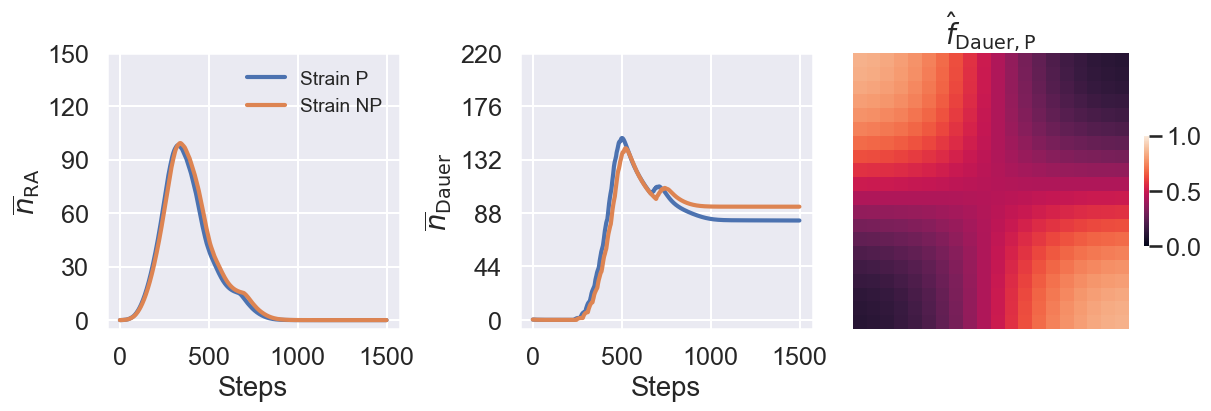

In [32]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('OP50')

dis_t = []
dis_a = []
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])


    
for i in [0, 1]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[0].set_yticks(np.linspace(0, 150, 6))
    
axes[1].set_yticks(np.linspace(0, 220, 6));

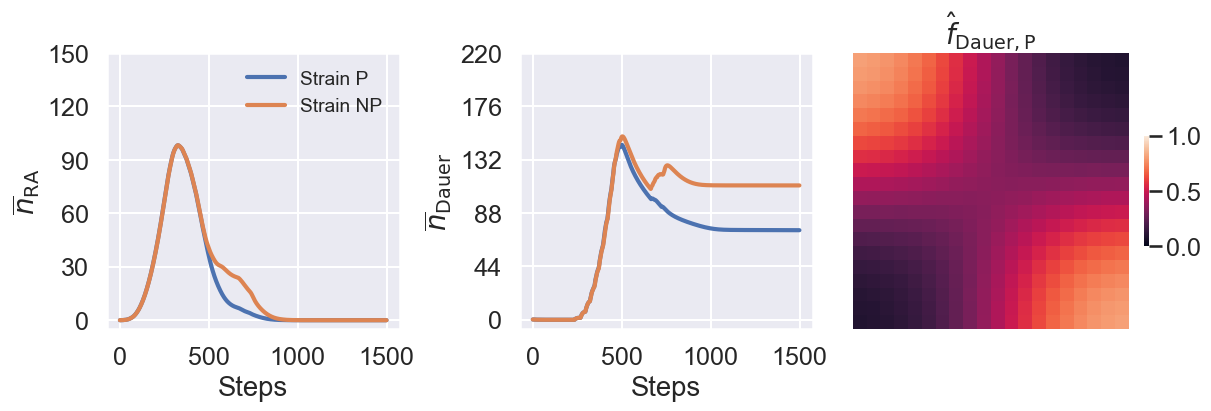

In [33]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [16.88, 80.77, 77.7 , 16.28,  1.4], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('OP50')

dis_t = []
dis_a = []
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])


    
for i in [0, 1]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[0].set_yticks(np.linspace(0, 150, 6))
    
axes[1].set_yticks(np.linspace(0, 220, 6));

# Figure 2C

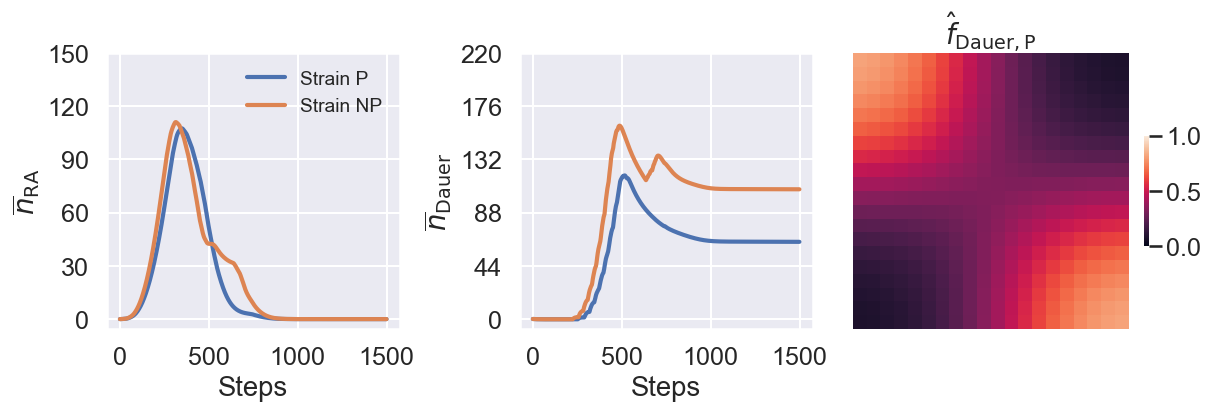

In [34]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('Novo')

dis_t = []
dis_a = []
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])


    
for i in [0, 1]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[0].set_yticks(np.linspace(0, 150, 6))
    
axes[1].set_yticks(np.linspace(0, 220, 6));

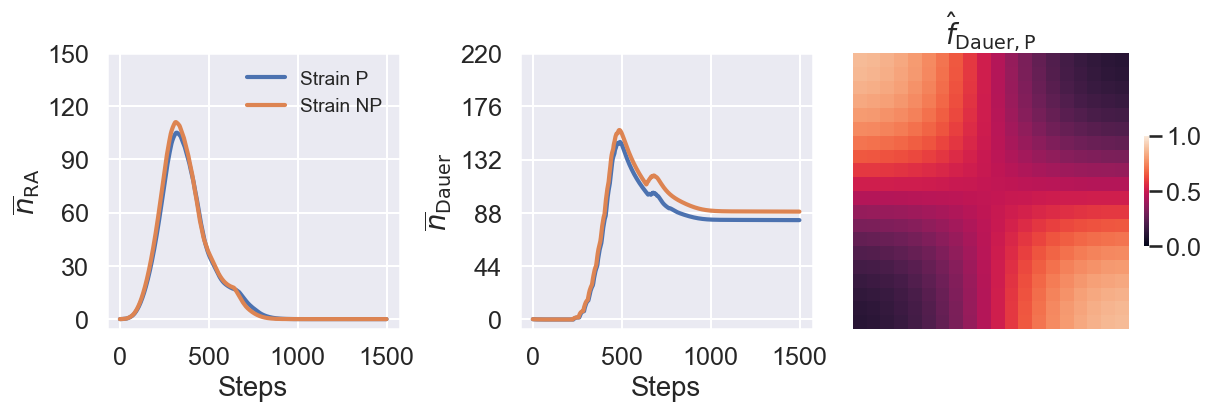

In [36]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [22.65, 68.45, 57.05, 33.4,  4.97]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('Novo')

dis_t = []
dis_a = []
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])


    
for i in [0, 1]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[0].set_yticks(np.linspace(0, 150, 6))
    
axes[1].set_yticks(np.linspace(0, 220, 6));

# Figure 3A

[[], []]

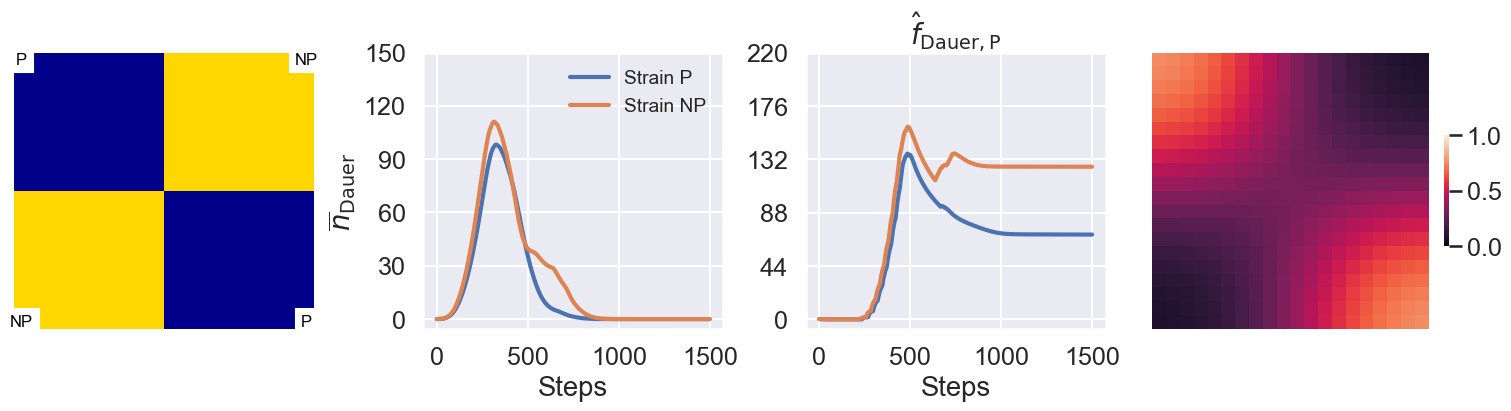

In [39]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(15, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
#metpop.add_pop_rand(['A','A','C','C'])
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('quad_1')

dis_t = []
dis_a = []
#time = 1500
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[1].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[1].legend(loc='best', frameon=False, fontsize='x-small')

axes[2].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[2].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[3], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[3].set_yticks(np.linspace(0, dim, dim))
axes[3].set_xticks(np.linspace(0, dim, dim))
yticks = axes[3].get_yticks()
axes[3].set_yticklabels(['' for i in yticks])
xticks = axes[3].get_xticks()
axes[3].set_xticklabels(['' for i in xticks])


    
for i in [1, 2]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[1].set_yticks(np.linspace(0, 150, 6))
    
axes[2].set_yticks(np.linspace(0, 220, 6))

resource_dist = np.zeros((dim, dim))
for i in metpop.index:
    if metpop.metapop[i].diet == 'Novo':
        resource_dist[i[0]][i[1]] = 1

sns.heatmap(resource_dist, ax = axes[0], cbar=False, cmap=['darkblue', 'gold'])

for label,i,j in metpop.init_pos: 
    axes[0].text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=12, color='black',backgroundcolor='white')
    
axes[0].set(yticks=[], xticks=[]);


# Figure 3B

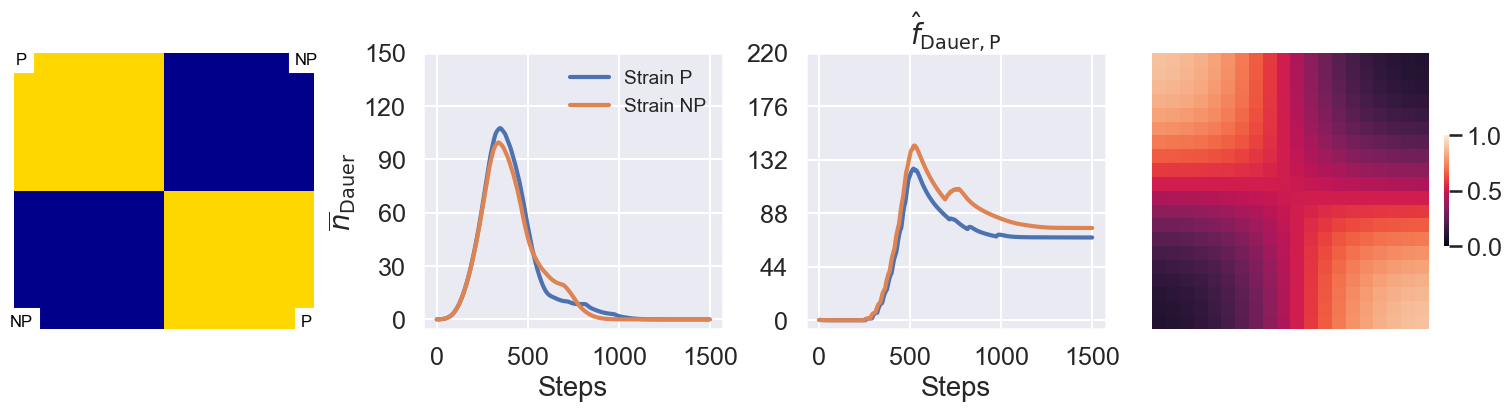

In [38]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(15, 4),
    constrained_layout=True)

axes = axes.flatten()
    
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
#metpop.add_pop_rand(['A','A','C','C'])
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('quad_2')

dis_t = []
dis_a = []
#time = 1500
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[1].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[1].legend(loc='best', frameon=False, fontsize='x-small')

axes[2].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[2].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[3], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[3].set_yticks(np.linspace(0, dim, dim))
axes[3].set_xticks(np.linspace(0, dim, dim))
yticks = axes[3].get_yticks()
axes[3].set_yticklabels(['' for i in yticks])
xticks = axes[3].get_xticks()
axes[3].set_xticklabels(['' for i in xticks])


    
for i in [1, 2]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[1].set_yticks(np.linspace(0, 150, 6))
    
axes[2].set_yticks(np.linspace(0, 220, 6))

resource_dist = np.zeros((dim, dim))
for i in metpop.index:
    if metpop.metapop[i].diet == 'Novo':
        resource_dist[i[0]][i[1]] = 1

sns.heatmap(resource_dist, ax = axes[0], cbar=False, cmap=['darkblue', 'gold'])

for label,i,j in metpop.init_pos: 
    axes[0].text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=12, color='black',backgroundcolor='white')
    
axes[0].set(yticks=[], xticks=[]);

## Randomized initial condition

The code to simulate scenarios where both the initial location of the populations seeded by the dauer larvae and the assignment of resource type to each population are randomized. Used to generate results of Fig 3C and Fig S6.

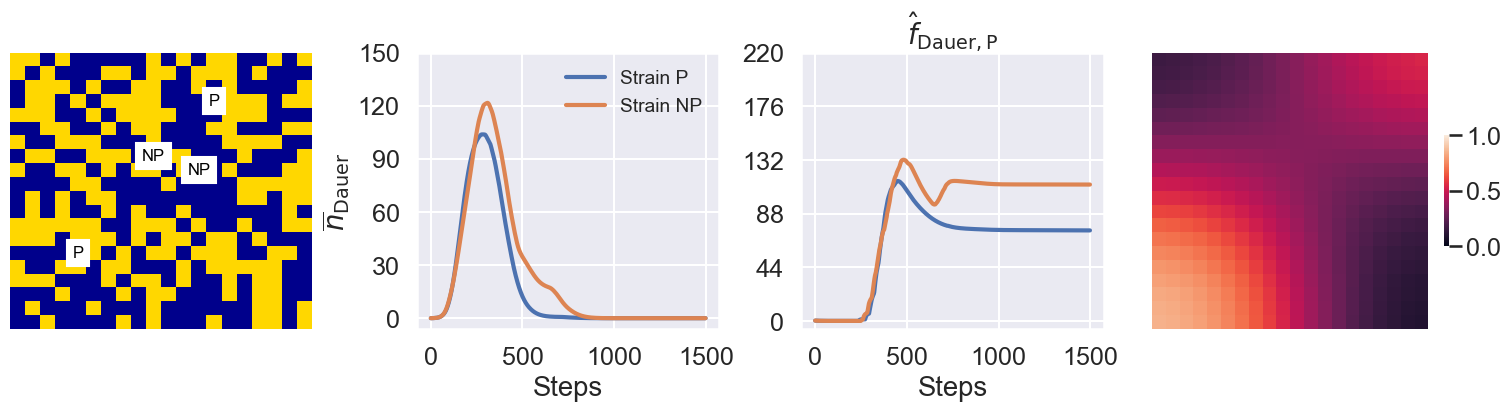

In [40]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(15, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
metpop.add_pop_rand(['A','A','C','C'])
#metpop.add_pop((0,0), 'A')
#metpop.add_pop((dim-1,dim-1), 'A')
#metpop.add_pop((0,dim-1), 'C')
#metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('rand')

dis_t = []
dis_a = []
#time = 1500
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[1].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[1].legend(loc='best', frameon=False, fontsize='x-small')

axes[2].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[2].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[3], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[3].set_yticks(np.linspace(0, dim, dim))
axes[3].set_xticks(np.linspace(0, dim, dim))
yticks = axes[3].get_yticks()
axes[3].set_yticklabels(['' for i in yticks])
xticks = axes[3].get_xticks()
axes[3].set_xticklabels(['' for i in xticks])


    
for i in [1, 2]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[1].set_yticks(np.linspace(0, 150, 6))
    
axes[2].set_yticks(np.linspace(0, 220, 6))

resource_dist = np.zeros((dim, dim))
for i in metpop.index:
    if metpop.metapop[i].diet == 'Novo':
        resource_dist[i[0]][i[1]] = 1

sns.heatmap(resource_dist, ax = axes[0], cbar=False, cmap=['darkblue', 'gold'])

for label,i,j in metpop.init_pos: 
    axes[0].text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=12, color='black',backgroundcolor='white')
    
axes[0].set(yticks=[], xticks=[]);

## Randomized boom-and-bust cycles

The code to simulate scenarios where the resources in the metapopulation are replenished and randomly reassigned at fixed intervals (default is 1000 steps). In addtion, the initial location of the populations seeded by the dauer larvae are randomized. Used to generate Fig 4 and Fig S7.

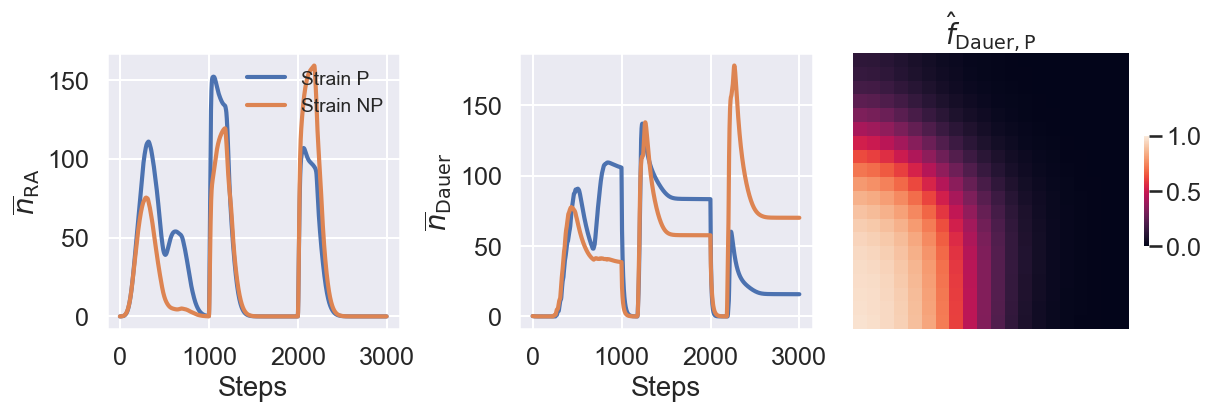

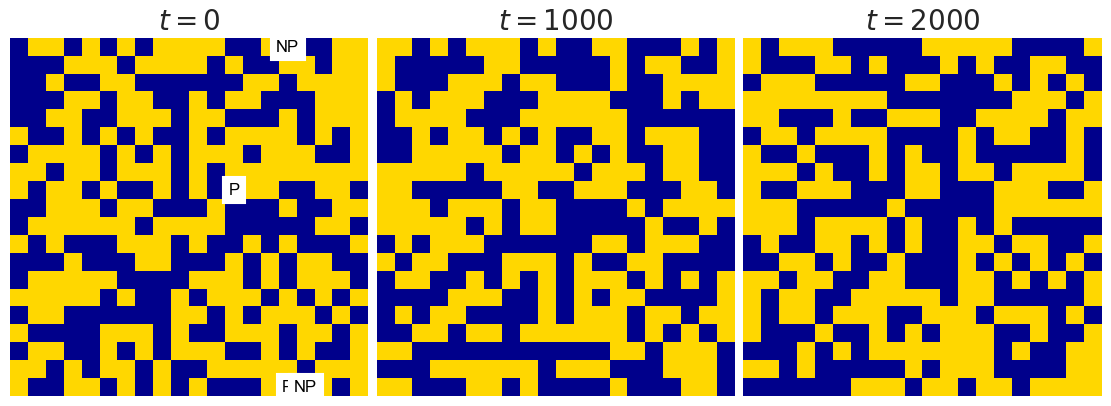

In [45]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True)

axes = axes.flatten()

axes[0].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[2].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0., 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=2)
metpop.fill_pop()
metpop.add_pop_rand(['A','A','C','C'])
metpop.set_diet_comp('rand')

resource_dist_t = []

dis_t = []
dis_a = []
time = 3000
for i in range(time):
    if not i%1000:
        metpop.reset_food()
        metpop.set_diet_comp('rand')
        resource_dist = np.zeros((dim, dim))
        for j in metpop.index:
            if metpop.metapop[j].diet == 'Novo':
                resource_dist[j[0]][j[1]] = 1 
        resource_dist_t.append(resource_dist)
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()

axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])



for i in [0, 1]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(11, 4),
    constrained_layout=True)

axes = axes.flatten()

sns.heatmap(resource_dist_t[0], ax = axes[0], cbar=False, cmap=['darkblue', 'gold'], square=True)

for label,i,j in metpop.init_pos: 
    axes[0].text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=12, color='black',backgroundcolor='white')

axes[0].set(yticks=[], xticks=[])

sns.heatmap(resource_dist_t[1], ax = axes[1], cbar=False, cmap=['darkblue', 'gold'], square=True)
axes[1].set(yticks=[], xticks=[])

sns.heatmap(resource_dist_t[2], ax = axes[2], cbar=False, cmap=['darkblue', 'gold'], square=True)
axes[2].set(yticks=[], xticks=[])

axes[0].set_title(r'$t=0$', fontsize=20)
axes[1].set_title(r'$t=1000$', fontsize=20)
axes[2].set_title(r'$t=2000$', fontsize=20);

# Figure S4

- A

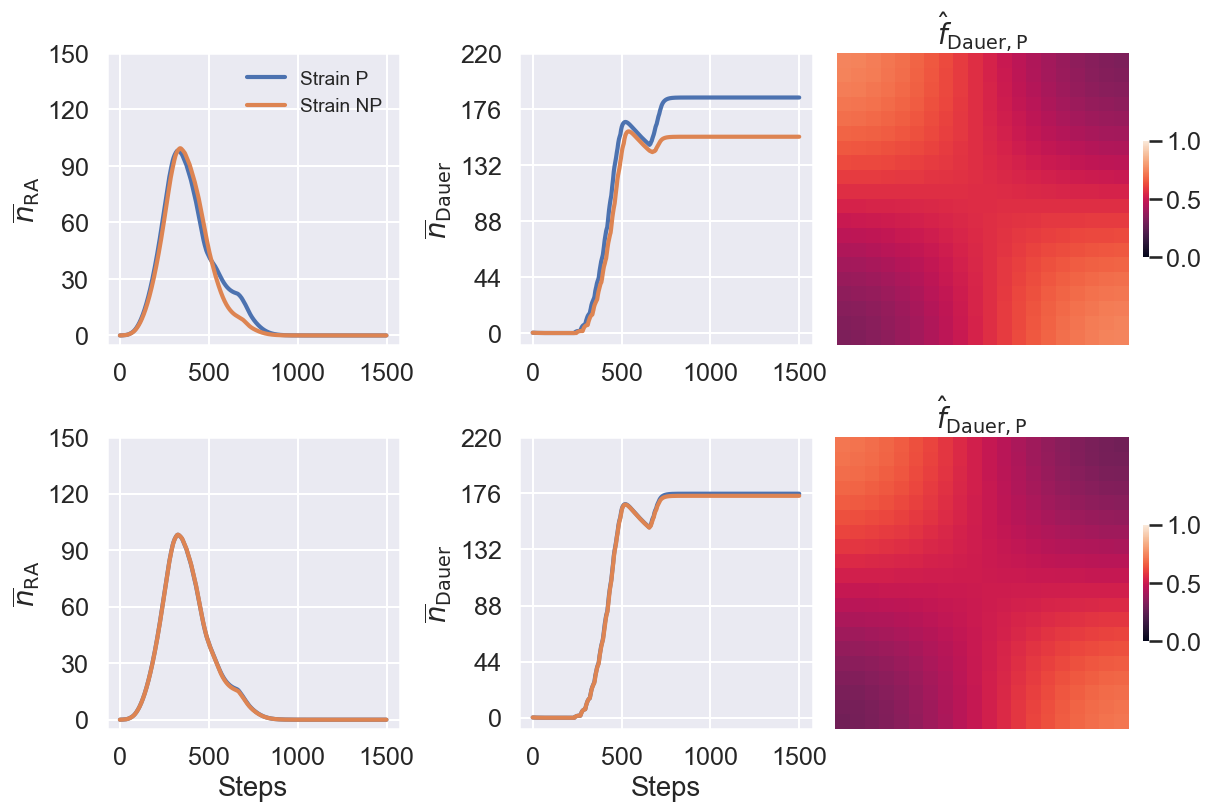

In [47]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 8),
    constrained_layout=True)

axes = axes.flatten()

for i in [1, 4]:
    axes[i].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
for i in [0, 3]:
    axes[i].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
    
for i in [2, 5]:
    axes[i].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')
    
fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=0.)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('OP50')

dis_t = []
dis_a = []
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [16.88, 80.77, 77.7 , 16.28,  1.4], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=0.)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('OP50')
dis_t = []
dis_a = []
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[3].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[3].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")
axes[4].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[4].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")



sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[5], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05})
axes[5].set_yticks(np.linspace(0, dim, dim))
axes[5].set_xticks(np.linspace(0, dim, dim))
yticks = axes[5].get_yticks()
axes[5].set_yticklabels(['' for i in yticks])
xticks = axes[5].get_xticks()
axes[5].set_xticklabels(['' for i in xticks]) 

for i in [0, 1, 3, 4]:
    axes[i].set_xticks(np.linspace(0, time, 4))
    
for i in [3, 4]:
    axes[i].set_xlabel('Steps')
    
for i in [0, 3]:
    axes[i].set_yticks(np.linspace(0, 150, 6))
    
for i in [1, 4]:
    axes[i].set_yticks(np.linspace(0, 220, 6));

- B

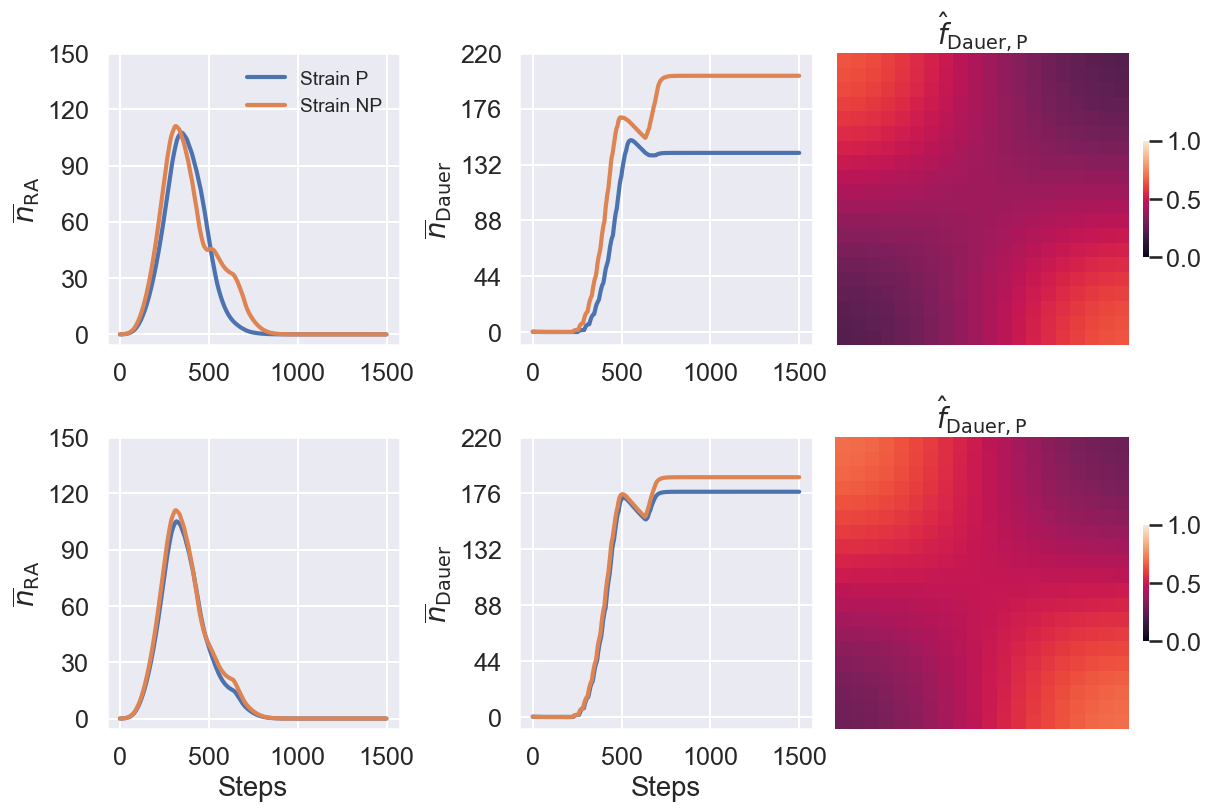

In [48]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 8),
    constrained_layout=True)

axes = axes.flatten()

for i in [1, 4]:
    axes[i].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
for i in [0, 3]:
    axes[i].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
    
for i in [2, 5]:
    axes[i].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')
    
fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=0.)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('Novo')

dis_t = []
dis_a = []
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[0].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[0].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[0].legend(loc='best', frameon=False, fontsize='x-small')

axes[1].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[2], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[2].set_yticks(np.linspace(0, dim, dim))
axes[2].set_xticks(np.linspace(0, dim, dim))
yticks = axes[2].get_yticks()
axes[2].set_yticklabels(['' for i in yticks])
xticks = axes[2].get_xticks()
axes[2].set_xticklabels(['' for i in xticks])

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [22.65, 68.45, 57.05, 33.4,  4.97]},
            'C': {'OP50': [16.88, 80.77, 77.7 , 16.28,  1.4], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=0.)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('Novo')
dis_t = []
dis_a = []
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[3].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[3].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")
axes[4].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[4].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")



sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[5], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05})
axes[5].set_yticks(np.linspace(0, dim, dim))
axes[5].set_xticks(np.linspace(0, dim, dim))
yticks = axes[5].get_yticks()
axes[5].set_yticklabels(['' for i in yticks])
xticks = axes[5].get_xticks()
axes[5].set_xticklabels(['' for i in xticks]) 

for i in [0, 1, 3, 4]:
    axes[i].set_xticks(np.linspace(0, time, 4))
    
for i in [3, 4]:
    axes[i].set_xlabel('Steps')
    
for i in [0, 3]:
    axes[i].set_yticks(np.linspace(0, 150, 6))
    
for i in [1, 4]:
    axes[i].set_yticks(np.linspace(0, 220, 6));

# Figure S5

- A

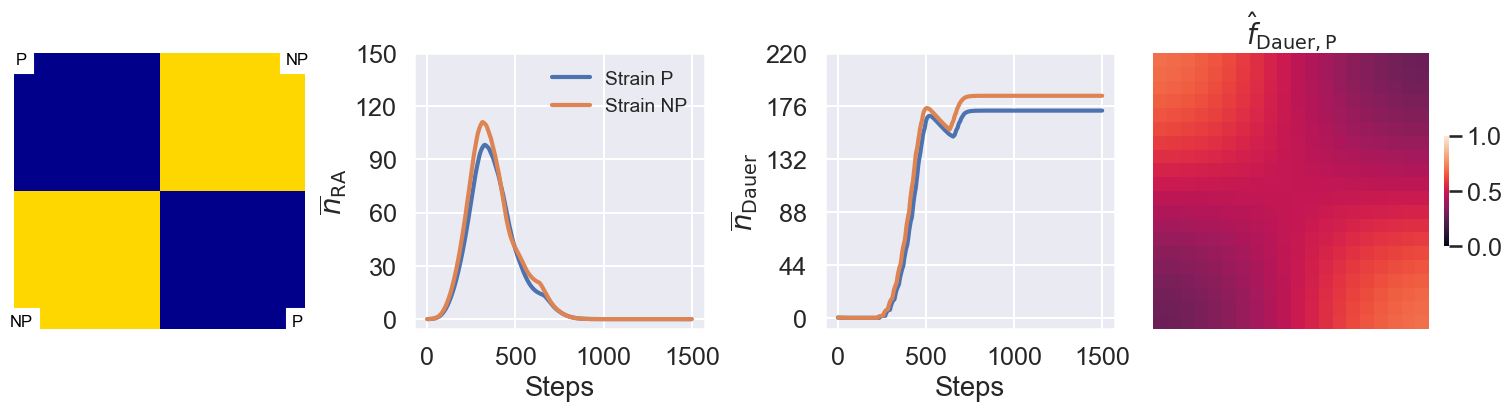

In [3]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(15, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[2].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[3].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=0.)
metpop.fill_pop()
#metpop.add_pop_rand(['A','A','C','C'])
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('quad_1')

dis_t = []
dis_a = []
#time = 1500
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[1].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[1].legend(loc='best', frameon=False, fontsize='x-small')

axes[2].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[2].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[3], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[3].set_yticks(np.linspace(0, dim, dim))
axes[3].set_xticks(np.linspace(0, dim, dim))
yticks = axes[3].get_yticks()
axes[3].set_yticklabels(['' for i in yticks])
xticks = axes[3].get_xticks()
axes[3].set_xticklabels(['' for i in xticks])


    
for i in [1, 2]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[1].set_yticks(np.linspace(0, 150, 6))
    
axes[2].set_yticks(np.linspace(0, 220, 6))

resource_dist = np.zeros((dim, dim))
for i in metpop.index:
    if metpop.metapop[i].diet == 'Novo':
        resource_dist[i[0]][i[1]] = 1

sns.heatmap(resource_dist, ax = axes[0], cbar=False, cmap=['darkblue', 'gold'])

for label,i,j in metpop.init_pos: 
    axes[0].text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=12, color='black',backgroundcolor='white')
    
axes[0].set(yticks=[], xticks=[]);

- B

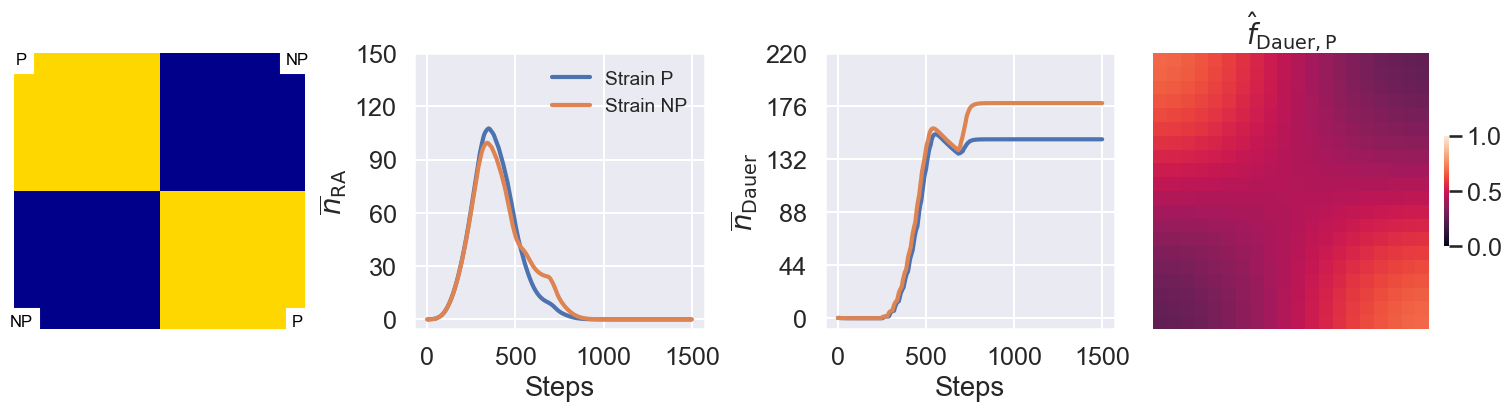

In [4]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(15, 4),
    constrained_layout=True)

axes = axes.flatten()
    
axes[1].set_ylabel(r'$\overline{n}_{\mathrm{RA}}$', fontsize=20)
axes[2].set_ylabel(r'$\overline{n}_{\mathrm{Dauer}}$')
axes[3].set_title(r'$\hat{f}_{\mathrm{Dauer}, \mathrm{P}}$')

fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}
disp_rate = [0.01, 0.01]
dim = 20
metpop = MetaPopulation(dim, fec_pars, mf_prob, r_rate=disp_rate, pred_rate=0.)
metpop.fill_pop()
#metpop.add_pop_rand(['A','A','C','C'])
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('quad_2')

dis_t = []
dis_a = []
#time = 1500
time = 1500
for i in range(time):
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    t1, t2 = metpop.ra_dist
    dis_t.append((a, b))
    dis_a.append((t1, t2))
    metpop.disperse_dauer()
    
axes[1].plot([np.mean(i[0]) for i in dis_a], lw=3, label="Strain P")
axes[1].plot([np.mean(i[1]) for i in dis_a], lw=3, label="Strain NP")

axes[1].legend(loc='best', frameon=False, fontsize='x-small')

axes[2].plot([np.mean(i[0]) for i in dis_t], lw=3, label="Strain P")
axes[2].plot([np.mean(i[1]) for i in dis_t], lw=3, label="Strain NP")


sns.heatmap(np.divide(dis_t[-1][0], dis_t[-1][0] + dis_t[-1][1]), ax=axes[3], vmin=0, vmax=1, cbar_kws={'ticks':[0, 0.5, 1], 'location':'right', 'shrink':0.4, 'pad':0.05}, square=True)
axes[3].set_yticks(np.linspace(0, dim, dim))
axes[3].set_xticks(np.linspace(0, dim, dim))
yticks = axes[3].get_yticks()
axes[3].set_yticklabels(['' for i in yticks])
xticks = axes[3].get_xticks()
axes[3].set_xticklabels(['' for i in xticks])


    
for i in [1, 2]:
    axes[i].set_xlabel('Steps')
    axes[i].set_xticks(np.linspace(0, time, 4))
    
axes[1].set_yticks(np.linspace(0, 150, 6))
    
axes[2].set_yticks(np.linspace(0, 220, 6))

resource_dist = np.zeros((dim, dim))
for i in metpop.index:
    if metpop.metapop[i].diet == 'Novo':
        resource_dist[i[0]][i[1]] = 1

sns.heatmap(resource_dist, ax = axes[0], cbar=False, cmap=['darkblue', 'gold'])

for label,i,j in metpop.init_pos: 
    axes[0].text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=12, color='black',backgroundcolor='white')
    
axes[0].set(yticks=[], xticks=[]);